# Redes Neuronales
## Trabajo Práctico N° 1 - Ejercicio 1
* Kammann, Lucas Agustín
* Gaytan, Joaquín Oscar

### Consultas y/o dudas
* Métricas del modelo (Matriz de confusión, exactitud, precisión, etc.)
* Procesamiento de los datos? (Filtrado)
* CountVectorizer, es necesario que lo hagamos a mano o podemos utilizar la librería de sci-kit-learn?
* Filtrado de numeros
* Filtrado de palabras

### Step by step
* Obtención del dataset (separando entre "train" y "test")
* Preprocesamiento de los datos
* Distribuciones condicionales (Verosimilitudes/Likelihood)
* Smoothing
* Probabilidad a Priori
* Clasificación (Naive Bayes Multinomial)
* Clasificación usando log posteriori
* Métricas

# Descripción del problema
Se desea armar un clasificador de correos electrónicos o noticias en función del tópico sobre el cual trata dicho correo electrónico o noticia, para ello, se modela el problema considerando una variable aleatoria discreta $X$ con distribución categórica de $k_x = 20$ categorías, siendo estas los tópicos posibles que pueden tratar los documentos clasificados.

$$X \sim Categorica(p_1, p_2, ..., p_{k_x})$$

Las características a analizar de los documentos para la clasificación, son las palabras. Se asume que el orden de las palabras no importa, que son independientes entre sí y que se encuentran identicamente distribuídas. De esta forma, se define una segunda variable aleatoria discreta $Y$ con distribución categórica de $k_y$ categorías, siendo estas las posibles palabras de nuestro vocabulario.

$$Y \sim Categorica(p_1, p_2, ..., p_{k_y})$$

# Esquema de clasificación
El modelo de clasificación es probabilístico, utilizando el criterio de máximo a posteriori, es decir se busca encontrar cuál es el tópico para el cual la probabilidad de que sea ese tópico sea máxima, dado la información que tenemos del mail o noticia.

$$P(y|x_1,...,x_n)$$

Aplicando la regla de Bayes,

$$P(y|x_1,...,x_n) = \frac{P(x_1,...,x_n|y) \cdot P(y)}{P(x_1,...,x_n)}$$

Luego, computacionalmente puede resultar demasiado compejo y costoso obtener las funciones de masa de probabilidad conjunta para las $n$ palabras dentro de un texto, dado cada posible tópico. Obtener tales funciones es un proceso de estimación, por lo tanto incluso si computacionalmente se pudiera estimar esa probabilidad conjunta, la cantidad de datos necesarios para poder estimarla con poco error resulta muy grande dada la cantidad de variables incluídas. Con lo cual, con no muchos datos también habría un error mayor en la predicción.

Para esto, se emplea un clasificador naive bayes, donde la condición naive o ingenuo impone independencia de las variables. De esta forma, la **verosimilitud** se aproxima y la expresión resulta como se muestra a continuación,

$$P(y|x_1,...,x_n) \approx \frac{P(x_1|y) \cdot ...  \cdot P(x_n|y) \cdot P(y)}{P(x_1,...,x_n)}$$

El denominador de esta expresión es invariante a las categorías de noticias o tópicos, es decir, es un número que se emplea por igual para cada probabilidad a posteriori. Entonces, como el proceso de clasificación sólo busca ver cuál de estas expresiones resulta mayor, si todas están afectadas por un factor idéntico, removerlo no afecta,

$$P(y|x_1,...,x_n) \approx \left[ \prod_{i=1}^{n} P(x_i|y) \right] \cdot P(y)$$

En conclusión,

$$\hat{y} = argmax_y \left[ \left[ \prod_{i=1}^{n} P(x_i|y) \right] \cdot P(y) \right]$$


# Parámetros del modelo

A modo de conclusión del análisis previo que describe el esquema de clasificación a emplear, se pueden determinar cuales son los parámetros del modelo que son necesarios estimar mediante el conjunto de datos de entrenamiento para tener listo el clasificador para predecir resultados.
1. $P(y)$, comúnmente llamadas en este contexto **probabilidades a priori**, es la distribución de la variable categórica tópico.
2. $P(x_i|y)$, es la distribución de la variable categórica palabra, condicionada al tópico.

# Preparación de la base de datos
Usamos la librería **sklearn** para descargar la base de datos de entrenamiento y de validación, ya que se encontraba disponible en sus datasets.

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

# Loading the datasets
train = fetch_20newsgroups(subset='train', shuffle=True)
test = fetch_20newsgroups(subset='test', shuffle=True)

# Categories
categories = train.target_names

# Train dataset, casting to numpy array
train_raw_input = np.array(train.data)
train_output = np.array(train.target)
train_size = len(train_raw_input)

# Test dataset, casting to numpy array
test_raw_input = np.array(test.data)
test_output = np.array(test.target)
test_size = len(test_raw_input)

# Logging useful information
print(f'Dataset Train: {train_size} elements')
print(f'Dataset Test: {test_size} elements')

Dataset Train: 11314 elements
Dataset Test: 7532 elements


# Explorando la base de datos

## Observando un correo electrónico de forma aleatoria
Buscamos de forma aleatoria un elemento dentro de la base de datos de entrenamiento, con el objetivo de visualizar cómo suelen ser los correos electrónicos de noticias que se poseen, para tener una mejor comprensión de qué podemos llegar a encontrarnos dentro del vocabulario o el documento a analizar.

### Observaciones
* El encabezado de todo mail nos informa quién lo envía, de qué organización y agrega otros campos de información
* Los campos del encabezado tienen palabras que en el lenguaje no tienen un significado, como el mail de una persona
* ¿Tiene sentido utilizar el encabezado en la clasificación?
* ¿Aporta más información que costo computacional tener en cuenta de qué dirección de correo proviene el mail?
* Si el formato del encabezado se replica siempre, ¿entonces no aporta información de clasificación por que no varía la distribución?
*

In [2]:
random_data = np.random.choice(train_raw_input)
print(random_data)

From: bc744@cleveland.Freenet.Edu (Mark Ira Kaufman)
Subject: Re: Nazi Eugenic Theories Circulated by CPR => (unconventional peace)
Organization: Case Western Reserve University, Cleveland, Ohio (USA)
Lines: 20
NNTP-Posting-Host: slc8.ins.cwru.edu


   First this man promotes the dissolution of the Jews through an
intermarriage process, and then says that it will be just a bunch
of 'fundamentalist' Jews who will object.  This clown even called
for 'buying' the dissolution of the Jewish people.

   Does this idiot mean to suggest that any Jew who objects to an
imibicilic notion like this is fundamentalist?  Or does he simply
mean to insult the orthodox by using the word 'fundamentalist?'

   I am not orthodox.  I am not fundamentalist.  I would desire a
genuine peace in the region more than this pinhead  Davidsson can
ever understand.  But when he shows his willingness to dismiss an
entire culture, he proves that the only thing more brain-boggling
than his stupidity is his willingness t

## Categorías
Dentro de la base de datos, los correos electrónicos que podemos encontrar pueden tratar de diferentes tópicos, y estos tópicos son las categorías de la variable aleatoria definida $X$.

In [3]:
import pprint

# Show the news categories
pprint.pprint(categories)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


# Preprocesamiento

Para trabajar con multinomial naive bayes es necesario poder modelar las características de entrada de forma numérica, para ello se definió una variable aleatoria categórica que corresponde a las palabras. Así, asumiendo que el orden de las palabras dentro de un texto no importa, y considerando que las palabras son independientes e igualmente distribuídas, para encontrar dicha distribución es necesario realizar un mapeo de las palabras con los valores numéricos de una variable y luego estimar dicha distribución.

## Tokenización
El proceso de tokenización implica tomar el texto e identificar todas las palabras distintas que se encuentran en el mismo y luego contar la cantidad de ocurrencias que tienen, es decir, cuál es la frecuencia absoluta de las palabras dentro de un texto.

In [14]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Importing and testing the CountVectorizer class of sklearn
vectorizer = TfidfVectorizer(min_df=0.01, strip_accents='ascii', stop_words='english', encoding='latin1')
train_input = vectorizer.fit_transform(train_raw_input)

Wall time: 5.45 s


In [15]:
import pandas as pd
pd.DataFrame(train_input.toarray(), columns=vectorizer.get_feature_names())

,00,000,01,02,03,04,05,07,08,10,...,wrong,wrote,yeah,year,years,yes,yesterday,york,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.097307,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.108936,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.081946,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.068815,0.000000,0.0,0.096065,0.0,0.0
11310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
11311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
11312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077478,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [16]:
print(train_input.shape)

(11314, 1921)


# Estimación de probabilidades a priori
Se computan las probabilidades a priori para las categorías, es decir, los tópicos. Se emplea una herramienta distinta a **matplotlib** para comparar el tiempo utilizada en el procesamiento. Se está estimando la siguiente función masa de probabilidad,
$$P(X=x) ; x = 0, 1, ..., 19$$

Para ello, se emplea como estimador la proporción de cada categoría dentro del conjunto de entrenamiento.

In [17]:
%%time

# For each category, filter the amount of occurences in the training dataset
# the compute the priori probability
priori_distribution = np.zeros(len(categories))
for index, category in enumerate(categories):
    frequency = (train_output == index).sum()
    priori_distribution[index] = frequency
priori_distribution /= priori_distribution.sum()

Wall time: 993 µs


# Estimación de distribución de probabilidad condicional
Para la estimación, se cuentan las apariciones de cada palabra dado el tópico de las noticias y luego se normaliza esa frecuencia absoluta para obtener la frecuencia relativa.



## Overfitting
El **overfitting** es un problema que ocurre cuando el modelo utilizado no es capaz de predecir correctamente frente a datos nuevos que no se encontraban en el conjunto de entrenamiento, lo cual le quita capacidad de generalizar, un aspecto fundamental en la resolución de problemas de inteligencia artificial. En este caso, para resolver el problema descripto se propone emplear un clasificador naive bayes multinomial, que puede traer apareado un problema de overfitting que se ilustra a continuación.

Sea un texto compuesto por $N$ palabras, para clasificarlo se busca la máxima probabilidad a posteriori, es decir aquella categoría $y$ para la cual la probabilidad de que ese texto pertenezca sea máxima a comparación de otras categorías,

$$P(y|x_1,...,x_N)=\frac{P(x_1,...,x_N|y) \cdot P(y)}{P(x_1,...,x_N)}$$

Aplicando naive bayes, se asumen que las palabras son independientes y luego se añade que sean idénticamente distruidas según el tipo de problema que nos proponemos resolver, entonces

$$P(y|x_1,...,x_N)=\frac{P(x_1|y) \cdot ... \cdot P(x_N|y) \cdot P(y)}{P(x_1,...,x_N)}$$

En función de cómo se estima la distribución de probabilidades, una palabra $x_1$ que no apareció en una categoría durante el entrenamiento fue ponderada con una probabilidad nula, lo cual hace que todo el producto se anule, y si la probabilidad fuera muy grande, por culpa de esta única palabra toda la probabilidad a posteriori se anula llevando a una predicción errónea. Para solucionar esto, se propone emplear el método de Laplacian Smoothing.

## Laplacian Smoothing
El método de Laplacian Smoothing consiste en agregar un cierto conocimiento a priori dentro de la distribución estimada, de forma tal que cuando no se posee demasiada evidencia durante el entrenamiento, la información aportada por tal conocimiento a priori nos permite evitar caer en el escenario de las probabilidades nulas.

El procedimiento consiste en fijar el valor de un **hiperparámetro** $\alpha$, que se suma como cantidad de ocurrencias a cada palabra durante el análisis de frecuencias absolutas en la etapa de estimación. Así, se introduce un conocimiento a priori de cantidad de ocurrencias igual para todas las palabras, es decir, estamos diciendo que sin información supondríamos que la distribución es uniforme. Por lo general, la magnitud de este parámetro define qué tanta información de entrenamiento se necesita para que deje de valer dicho conocimiento a priori.

### Discusiones sobre Laplacian Smoothing
* https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece
* https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf
* https://stats.stackexchange.com/questions/108797/in-naive-bayes-why-bother-with-laplace-smoothing-when-we-have-unknown-words-in
* https://courses.cs.washington.edu/courses/cse446/20wi/Section7/naive-bayes.pdf

In [18]:
%%time

# Separate the matrix of documents (mails) and occurrences of words for each category
# and compute the normalized distribution to get the likelihood for each category
alpha = 0.01
word_distribution = np.zeros((len(categories), len(vectorizer.vocabulary_.keys())), dtype=np.longdouble)
for index, category in enumerate(categories):
  distribution = (train_input[train_output == index][:]).sum(axis=0) + alpha
  word_distribution[index,:] = distribution / distribution.sum()

Wall time: 20.9 ms


In [19]:
print(f'The word distribution is conditioned to {word_distribution.shape[0]} topics and contains {word_distribution.shape[1]} words')

The word distribution is conditioned to 20 topics and contains 1921 words


## Distribución de clases
Se calcula y grafica el histograma de los tópicos de las noticias o correos electrónicos utilizando la librería **matplotlib**. Del resultado obtenido, se pueden hacer algunos comentarios,
* A simple vista, la distribución es relativamente cercana a una distribución uniforme
* El clasificador trivial tendría una exactitud de aproximadamente 0,05

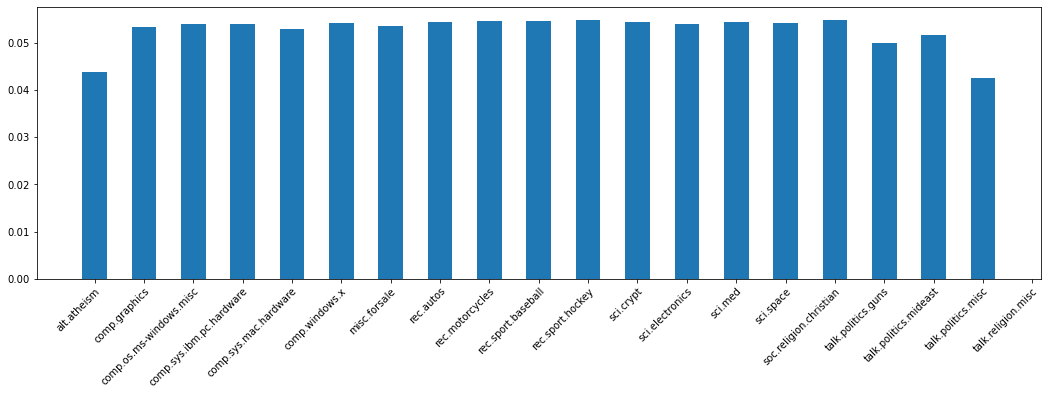

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Histogram for the categories in the training set
fig, ax = plt.subplots(1, figsize=(18, 5))
ax.hist(train_output, bins=np.arange(len(categories))-0.5, rwidth=0.5, density=True)
ax.set_xticks(np.arange(0, 20, 1))
ax.set_xticklabels(categories, rotation=45, rotation_mode="anchor", ha="right")

plt.show()

# Distribucion de palabras por tópico
Restringimos la distribución a un rango de las palabras para evitar tener un tiempo largo de ejecución, ya que de todas formas es una representación gráfica para visualizar las diferencias entre distribuciones.

Distribution from word 23 to word 123 in the vocabulary


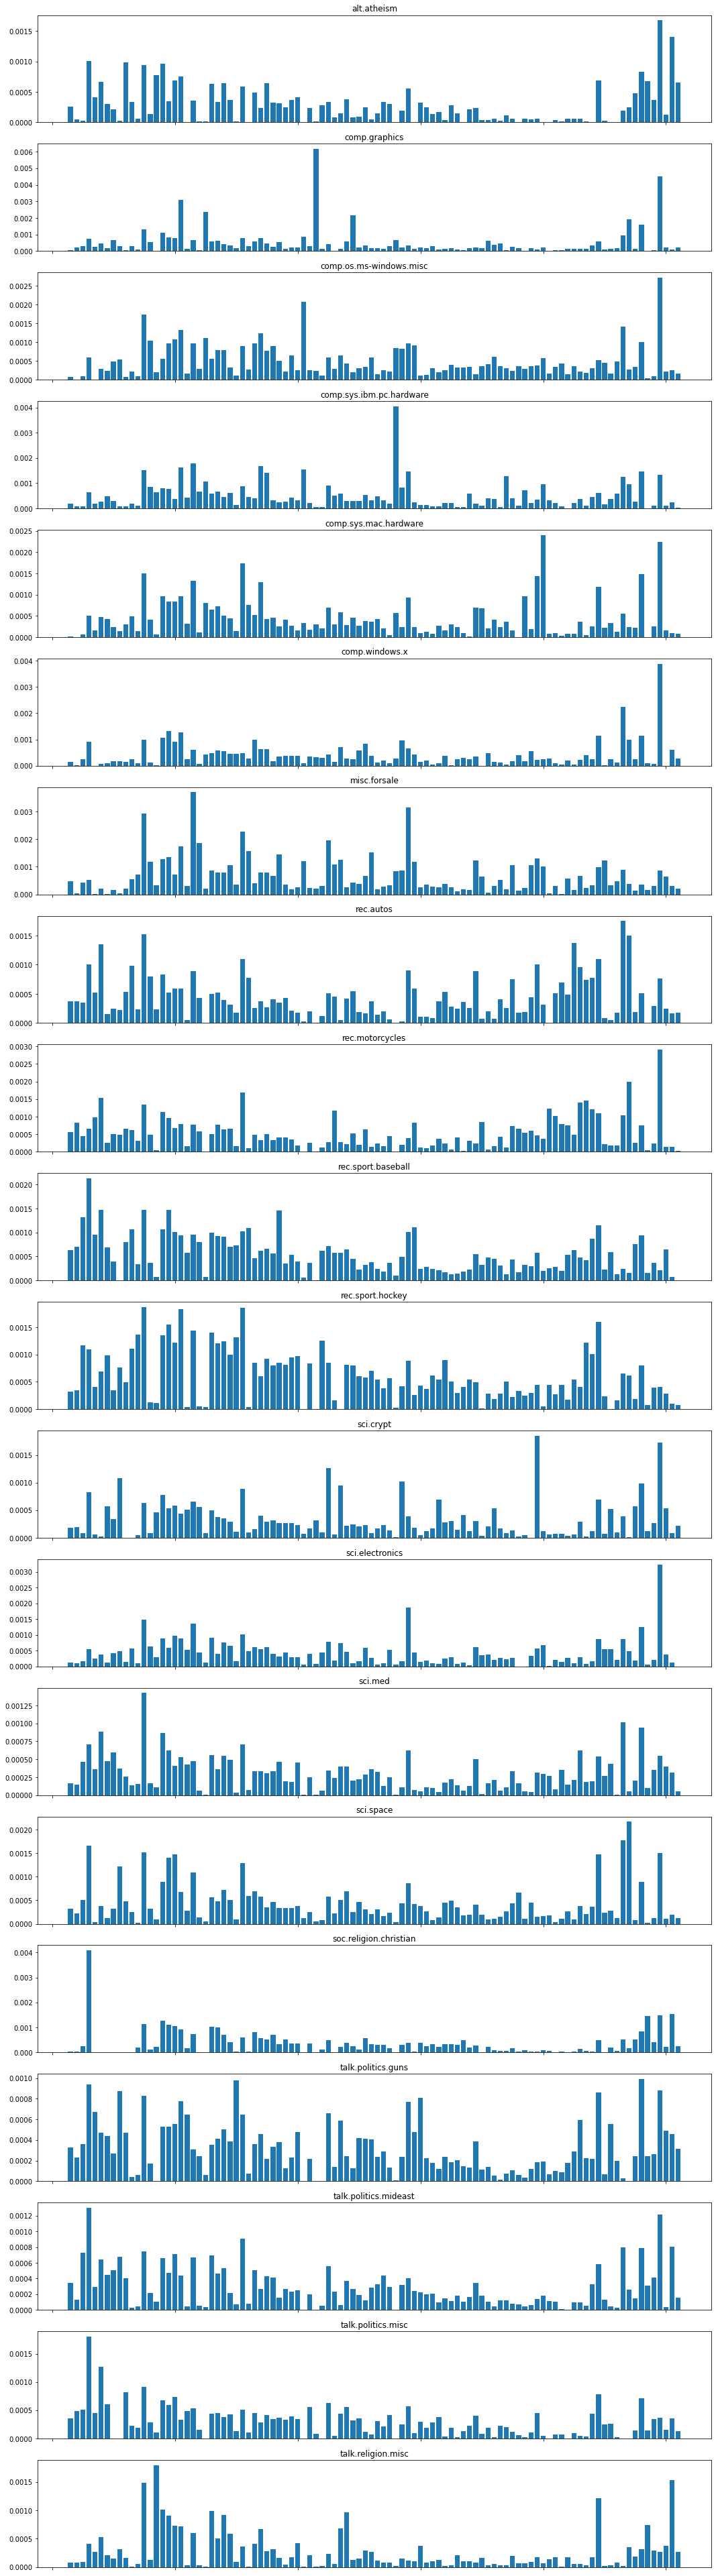

In [54]:
# Parameters of the reduced data set
qty_word = 100
min_word_index = np.random.randint(0, len(vectorizer.get_feature_names()))
max_word_index = min_word_index + qty_word

# Logging...
print(f'Distribution from word {min_word_index} to word {max_word_index} in the vocabulary')

# Bar plot with the conditioned distribution for each topic
fig, ax = plt.subplots(len(categories), figsize=(18, 70))
for index, category in enumerate(categories):
    ax[index].bar(np.arange(min_word_index, max_word_index), word_distribution[index,min_word_index:max_word_index])
    ax[index].set_title(category)
    ax[index].tick_params(labelbottom=False)
plt.show()

# Clasificación por máximo a posteriori
Como ya se explicó anteriormente, el esquema de clasificación consiste en buscar el máximo a posteriori. Para ello, se busca calcular

$$P(y|x_1,...,x_n) \approx \left[ \prod_{i=1}^{n} P(x_i|y) \right] \cdot P(y)$$

En este caso, por cada palabra que aparezca, multiplicamos por su probabilidad condicionada tantas veces como aparezca durante la productoria. Esto implica, que podríamos modificar el orden de la operación iterando sobre las palabras del vocabulario,

$$P(y|x_1,...,x_n) \approx \left[ \prod_{i=1}^{m} P(v_i|y)^{\# v_i} \right] \cdot P(y)$$

Es decir, se hace la productoria sobre las palabras del vocabulario $v_i$, y cada una de ellas se encuentra elevada a la cantidad de veces que aparece esa palabra dentro del texto, es decir, $\# v_i$.

Entonces, en la práctica se tiene,
* Una matriz que contiene para cada tópico (filas) las probabilidades de cada palabra (columnas), es decir con una dimensión de k x m.
* Un vector con las probabilidades a priori, es decir de dimensión k x 1. 
* Un vector con la cantidad de ocurrencias de cada palabra de un documento, es decir, de dimensión k x 1.

Así, se eleve la matriz al vector de ocurrencias y luego se ejecuta el producto punto con el vector de probabilidades a priori. Finalmente, se obtiene con esto un vector con el valor numérico para comparar cada categoría.

### Problema numérico
Si el preprocesamiento no se vuelve lo suficientemente estricto y no limita el vocabulario, la cantidad de palabras provoca que los valores numéricos obtenidos en la verosimilitud sean demasiado chicos y empiezan a darse errores numéricos por la precisión del punto flotante empleado por NumPy.

Este problema se encontró comparando este modelo con el de log probabilidades, y se pudo observar que si se escala la distribución (no se la normaliza), entonces el problema numérico desaparece.

In [60]:
%%time

# Taking a subset of the testing set, to avoid using the complete set
# when the algorithm is too slow... remember this is not strictly the test
# or validation of the model, we are doing only an analysis and it is not required
# for us in this instance to use the complete set
sub_test_input_size = 10
sub_text_raw_input = test_raw_input[:sub_test_input_size]
sub_test_output = test_output[:sub_test_input_size]
sub_test_input = vectorizer.transform(sub_text_raw_input)

# Computing predictions for each input
predictions = np.zeros(sub_test_input.shape[0], dtype=int)
for input_index in range(sub_test_input.shape[0]):
    # Computing the posteriori probability
    posteriori_unnormalized = ((word_distribution) ** sub_test_input.toarray()[input_index]).prod(axis=1) * priori_distribution

    # Choosing the maximum posteriori probability as the prediction
    predictions[input_index] = posteriori_unnormalized.argmax()

Wall time: 15 ms


In [61]:
# Computing the accuracy of the model
accuracy = (predictions == sub_test_output).sum() / sub_test_input_size
print(f'Accuracy obtained: {accuracy}')

Accuracy obtained: 0.6


# Clasificación utilizando log probabilidades

Si consideramos que el denominador de la expresión del máximo a posteriori es un término invariante a las categorías, por lo cual lo removemos, y luego aplicamos el logaritmo natural, obtenemos una expresión de la siguiente forma,

$$ln[P(y|x_1,...,x_N)] \propto ln[P(x_1|y)] + ... + ln[P(x_n|y)] + ln[P(y)]$$

Luego, si aplicamos esto mismo sobre la otra forma de ejecutar la probabilidad a posteriori, donde en vez de iterar sobre las palabras del texto se itera sobre las palabras del vocabulario, entonces esta misma operación queda,

$$ln[P(y|x_1,...,x_N)] \propto \# v_1 \cdot ln[P(v_1|y)] + ... + \# v_n \cdot ln[P(v_n|y)] + ln[P(y)]$$

Entonces, matemáticamente se puede escribir como el producto punto entre un vector con las ocurrencias de las palabras en el texto y un vector con las log probabilidades de cada palabra, y finalmente sumarle el vector con las log probabilidades a priori.


In [ ]:
%%time

# Log probabilities
log_priori = np.log(priori_distribution)
log_prob = np.log(word_distribution)

# Data, target and vectorizer
sub_test_input_size = test_size
sub_text_raw_input = test_raw_input[:sub_test_input_size]
sub_test_output = test_output[:sub_test_input_size]
sub_test_input = vectorizer.transform(sub_text_raw_input)

In [ ]:
%%time

# Computing the log posteriori probability
log_posteriori = np.dot(log_prob, sub_test_input.todense().transpose()) + (log_priori.reshape(-1, 1) * np.ones(sub_test_input_size))

In [ ]:
%%time

# Choosing the maximum log posteriori probability as the prediction
predictions = np.zeros(sub_test_input.shape[0], dtype=int)
for input_index in range(input_size):
    predictions[input_index] = log_posteriori[:,input_index].argmax()

## Métricas

* https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/

# TODO! Explicar cada métrica y cada fórmula

In [ ]:
from sklearn import metrics

# Accuracy (Exactitud)
accuracy = metrics.accuracy_score(sub_test_output, predictions)
print(f'Accuracy obtained: {accuracy}')

In [ ]:
# Confusion Matrix
cmatrix = metrics.confusion_matrix(sub_test_output, predictions)
plt.matshow(cmatrix)
plt.colorbar()
plt.title("Matriz de Confusión")

In [ ]:
# Precision
precision = metrics.precision_score(sub_test_output, predictions, average=None)
print(precision)

In [ ]:
# Recall
recall = metrics.recall_score(sub_test_output, predictions, average=None)
print(recall)

In [ ]:
# F1 score
f1 = metrics.f1_score(sub_test_output, predictions, average=None)
print(f1)

In [ ]:
print(metrics.classification_report(sub_test_output, predictions))